## This is the Orginal Network provided by Tananka Sensei

In [3]:
import torch
import torch.nn as nn
from torch.nn.modules.linear import Linear
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
# Hyper-parameters
num_epochs = 80
batch_size = 100
learning_rate = 0.001

# Image preprocessing modules
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',train=True,transform=transform,
                      download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data/',train=False,transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,
                       shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,
                      shuffle=False)

Files already downloaded and verified


In [6]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)


In [7]:
class SimpleNet(nn.Module):
    def __init__(self,num_classes=10):
        super(SimpleNet,self).__init__()
        self.conv1= conv3x3(in_channels=3,out_channels=32)
        self.relu =nn.ReLU(True)
        self.maxpooling1 = nn.MaxPool2d(2,2)
        self.conv2 =conv3x3(32,64)
        self.linear1 = nn.Linear(16384,128)
        self.linear2 = nn.Linear(128,num_classes)
        self.dropout = nn.Dropout2d(0.5)
    def forward(self,x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpooling1(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = out.view(out.size(0), -1)
        out = self.linear1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.linear2(out)
        return out


model = SimpleNet(num_classes=10).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train the model
summary_writer = SummaryWriter("tanaka_report/simple")

total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epochs):
    # train here 
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            summary_writer.add_scalar("Current Loss: ",loss.item())
    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)
        summary_writer.add_scalar("Learning_Rate",curr_lr,epoch+1)
    
    # Test
    if (epoch+1)%2==0:
        print("Beigin test")
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
            acc_rate = 100 * correct / total
            summary_writer.add_scalar("ACC_on_Test",acc_rate,epoch+1)
            print("test done! acc is : ",acc_rate)

# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'liuzihua_simple.ckpt')


Epoch [1/80], Step [100/500] Loss: 1.9736
Epoch [1/80], Step [200/500] Loss: 1.7613
Epoch [1/80], Step [300/500] Loss: 1.6685
Epoch [1/80], Step [400/500] Loss: 1.6475
Epoch [1/80], Step [500/500] Loss: 1.7268
Epoch [2/80], Step [100/500] Loss: 1.6254
Epoch [2/80], Step [200/500] Loss: 1.5050
Epoch [2/80], Step [300/500] Loss: 1.6629
Epoch [2/80], Step [400/500] Loss: 1.4562
Epoch [2/80], Step [500/500] Loss: 1.5832
Beigin test
test done! acc is :  53.64
Epoch [3/80], Step [100/500] Loss: 1.5249
Epoch [3/80], Step [200/500] Loss: 1.5972
Epoch [3/80], Step [300/500] Loss: 1.2738
Epoch [3/80], Step [400/500] Loss: 1.4027
Epoch [3/80], Step [500/500] Loss: 1.2529
Epoch [4/80], Step [100/500] Loss: 1.3371
Epoch [4/80], Step [200/500] Loss: 1.5547
Epoch [4/80], Step [300/500] Loss: 1.1915
Epoch [4/80], Step [400/500] Loss: 1.2564
Epoch [4/80], Step [500/500] Loss: 1.3457
Beigin test
test done! acc is :  59.66
Epoch [5/80], Step [100/500] Loss: 1.2665
Epoch [5/80], Step [200/500] Loss: 1.279

Epoch [36/80], Step [300/500] Loss: 0.6693
Epoch [36/80], Step [400/500] Loss: 0.7517
Epoch [36/80], Step [500/500] Loss: 0.8978
Beigin test
test done! acc is :  74.67
Epoch [37/80], Step [100/500] Loss: 0.7870
Epoch [37/80], Step [200/500] Loss: 0.9883
Epoch [37/80], Step [300/500] Loss: 0.9603
Epoch [37/80], Step [400/500] Loss: 0.8279
Epoch [37/80], Step [500/500] Loss: 0.9790
Epoch [38/80], Step [100/500] Loss: 0.8684
Epoch [38/80], Step [200/500] Loss: 0.8802
Epoch [38/80], Step [300/500] Loss: 0.7457
Epoch [38/80], Step [400/500] Loss: 0.8470
Epoch [38/80], Step [500/500] Loss: 0.8833
Beigin test
test done! acc is :  74.93
Epoch [39/80], Step [100/500] Loss: 0.7662
Epoch [39/80], Step [200/500] Loss: 0.8470
Epoch [39/80], Step [300/500] Loss: 0.7495
Epoch [39/80], Step [400/500] Loss: 0.8148
Epoch [39/80], Step [500/500] Loss: 0.7657
Epoch [40/80], Step [100/500] Loss: 0.7588
Epoch [40/80], Step [200/500] Loss: 0.8257
Epoch [40/80], Step [300/500] Loss: 0.9468
Epoch [40/80], Step

Epoch [71/80], Step [300/500] Loss: 0.7240
Epoch [71/80], Step [400/500] Loss: 0.7460
Epoch [71/80], Step [500/500] Loss: 0.7862
Epoch [72/80], Step [100/500] Loss: 0.8976
Epoch [72/80], Step [200/500] Loss: 0.8673
Epoch [72/80], Step [300/500] Loss: 0.8591
Epoch [72/80], Step [400/500] Loss: 0.7703
Epoch [72/80], Step [500/500] Loss: 0.9863
Beigin test
test done! acc is :  76.62
Epoch [73/80], Step [100/500] Loss: 0.9055
Epoch [73/80], Step [200/500] Loss: 0.8523
Epoch [73/80], Step [300/500] Loss: 0.9040
Epoch [73/80], Step [400/500] Loss: 0.7952
Epoch [73/80], Step [500/500] Loss: 0.8083
Epoch [74/80], Step [100/500] Loss: 0.7260
Epoch [74/80], Step [200/500] Loss: 0.6962
Epoch [74/80], Step [300/500] Loss: 0.7148
Epoch [74/80], Step [400/500] Loss: 0.9943
Epoch [74/80], Step [500/500] Loss: 0.8169
Beigin test
test done! acc is :  76.53
Epoch [75/80], Step [100/500] Loss: 0.6817
Epoch [75/80], Step [200/500] Loss: 0.7862
Epoch [75/80], Step [300/500] Loss: 0.7583
Epoch [75/80], Step

In [8]:
# Test the model
model.eval()
predicted_result_list = []
gt_result_list= []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predict_array = predicted.cpu().numpy()
        predicted_result_list.extend(predict_array)
        gt_label =labels.cpu().numpy()
        gt_result_list.extend(gt_label)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(len(predicted_result_list))
print(len(gt_result_list))

10000
10000


In [9]:
import sklearn.metrics
import numpy as np
import matplotlib.pyplot as plt

acc = sklearn.metrics.accuracy_score(gt_result_list,predicted_result_list)

In [10]:
acc

0.7673

## As we can see, the sample code provided by Tanaka Sensei is 76.73%

## Next I will show the confuse matrix of the sample code


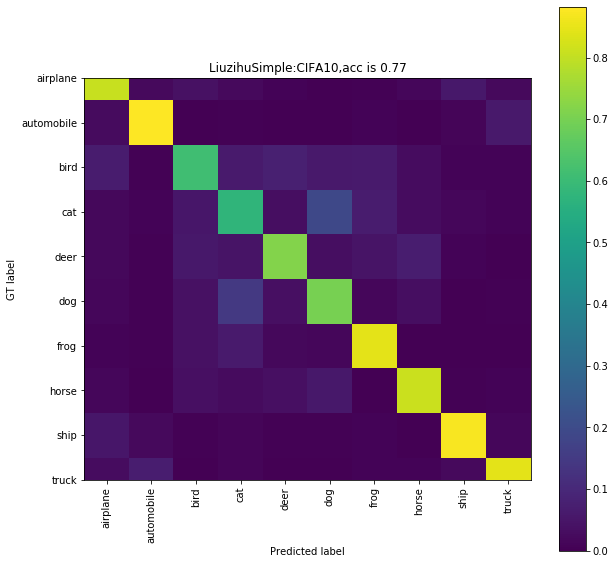

In [11]:
# get confusion matrix
def plot_confusion_matrix(cm, labels_name, title,figname):
    plt.figure(figsize=(10,10))
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]    # 归一化
    plt.imshow(cm, interpolation='nearest')    # 在特定的窗口上显示图像
    plt.title(title)    # 图像标题
    plt.colorbar()
    num_local = np.array(range(len(labels_name)))    
    plt.xticks(num_local, labels_name, rotation=90)    # 将标签印在x轴坐标上
    plt.yticks(num_local, labels_name)    # 将标签印在y轴坐标上
    plt.ylabel('GT label')    
    plt.xlabel('Predicted label')
    plt.savefig(figname, format='png')
    plt.show()


import numpy as np
import matplotlib.pyplot as plt
labels_name =["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
confusion_matrix = sklearn.metrics.confusion_matrix(gt_result_list,predicted_result_list)
plot_confusion_matrix(cm = confusion_matrix,labels_name=labels_name,title="LiuzihuSimple:CIFA10,acc is {}" .format(round(acc,2)), figname="LIUZIHA_simple")

## Next try the model to do prediction

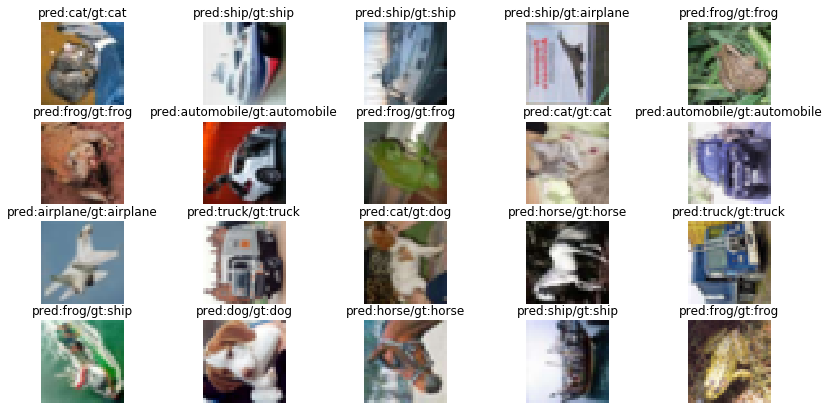

In [12]:
# Visualization
vis_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=1,
                      shuffle=False)
model.eval()
visuilzation_images = []
predict_labels = []
gt_labels = []

with torch.no_grad():
    correct = 0
    total = 0
    cnt =0
    for images, labels in vis_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        predict_array = predicted.cpu().numpy()
        
        gt_label =labels.cpu().numpy()
        
        vis_image = images.squeeze(0)
        vis_image = vis_image.permute(2,1,0)
        vis_image = vis_image.cpu().numpy()
        
        visuilzation_images.append(vis_image)
        predict_labels.append(predict_array[0])
        gt_labels.append(gt_label[0])
        
        cnt = cnt+1
        if cnt>19:
            break
plt.figure(figsize=(14,7))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.title("pred:{}/gt:{}".format(labels_name[predict_labels[i]],labels_name[gt_labels[i]]))
    plt.axis("off")
    plt.imshow(visuilzation_images[i])
plt.savefig("predict_result_simple.png")
plt.show()
